# SF crime data analysis and modeling


## Background
This analysis provided insights into the patterns of crime in San Francisco, including high-crime areas, peak times for criminal activity, and prevalent crime types. Based on these findings, we offered actionable recommendations for visitors, residents, and law enforcement in SF to enhance safety and awareness.

## Import packages and load data

In [0]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sb
import os
os.environ["PYSPARK_PYTHON"] = "python3"


The dataset contained 550M crime-related records from 37 crime category in San Francisco from 2023/01/01 to 2018/05/15.

In [0]:
# SF gov download data
import urllib.request
urllib.request.urlretrieve("https://data.sfgov.org/api/views/tmnf-yvry/rows.csv?accessType=DOWNLOAD", "/tmp/myxxxx.csv")
dbutils.fs.mv("file:/tmp/myxxxx.csv", "dbfs:/laioffer/spark_hw1/data/sf_10_07.csv") # save to local
display(dbutils.fs.ls("dbfs:/laioffer/spark_hw1/data/"))


In [0]:
data_path = "dbfs:/laioffer/spark_hw1/data/sf_10_07.csv"
# use this file name later

In [ ]:

from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("crime analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

df_opt1 = spark.read.format("csv").option("header", "true").load(data_path)
#display(df_opt1)
df_opt1.createOrReplaceTempView("sf_crime")



In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import date_format, to_date
# Convert 'Date' column to DateType
df_opt1 = df_opt1.withColumn("Date",to_date(df_opt1.Date, "MM/dd/yyyy")) 

# Get the maximum date from the 'Date' column
max_date = df_opt1.agg(F.max('Date')).collect()[0][0]
min_date = df_opt1.agg(F.min('Date')).collect()[0][0]
unique_category_count = df_opt1.select('Category').distinct().count()

In [0]:
print(f"The data set is from {min_date} to {max_date} with {unique_category_count} categories")

The data set is from 2003-01-01 to 2018-05-15 with 37 categories


## Crimes for different category.

The most common category was "Larceny/Theft" , which indicated that theft were a predominant concern in SF. Categories such as "Treason" and "Pornography/Obscene Material" were extremely rare, suggesting these crimes were either underreported or not as widespread in SF.


In [0]:
q1_result = df_opt1.groupBy("category").count().orderBy("count", ascending=False)
display(q1_result)


category,count
LARCENY/THEFT,477975
OTHER OFFENSES,301874
NON-CRIMINAL,236928
ASSAULT,167042
VEHICLE THEFT,126228
DRUG/NARCOTIC,117821
VANDALISM,114718
WARRANTS,99821
BURGLARY,91067
SUSPICIOUS OCC,79087


In [0]:
# toPandas() -> pandas dataframe, could use pandas api
q1_result_df = q1_result.toPandas()

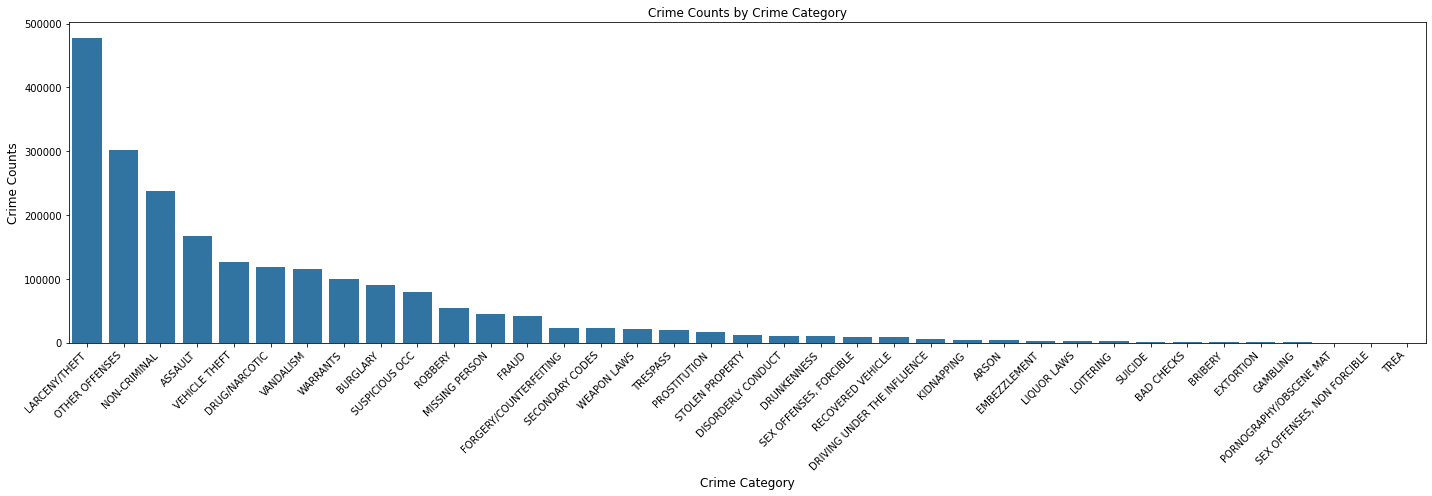

In [0]:
fig, axp = plt.subplots(1, 1, figsize=[20, 7])
sb.barplot(x='category', y='count', data=q1_result_df, ax=axp, color='C0')
axp.set_title('Crime Counts by Crime Category')
axp.set_xlabel('Crime Category', fontsize=12)
axp.set_ylabel('Crime Counts', fontsize=12)
axp.set_xticklabels(axp.get_xticklabels(), rotation=45, horizontalalignment='right') 
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


## Crimes for different district, and visualize your results


Southern SF, Mission and northern SF had relatively higher crime incidents. 

The high crimes in southern SF might because it was a hub for tourism, commerce, transportation. Its high population density, combined with the influx of tourists and commuters, created more opportunities for crimes.

For Mission district and northern districts, historically, faced issues with homeless, drug addiction, and mental health problems. These social issues often correlated with higher rates of crime, including drug-related offenses and petty theft.

In [0]:
q2_result = df_opt1.groupBy("PdDistrict").count().orderBy("count", ascending=False)
display(q2_result)

PdDistrict,count
SOUTHERN,390692
MISSION,288985
NORTHERN,266435
CENTRAL,221923
BAYVIEW,205480
TENDERLOIN,186954
INGLESIDE,181092
TARAVAL,155461
PARK,119698
RICHMOND,112804


In [0]:
q2_result_df = q2_result.toPandas()

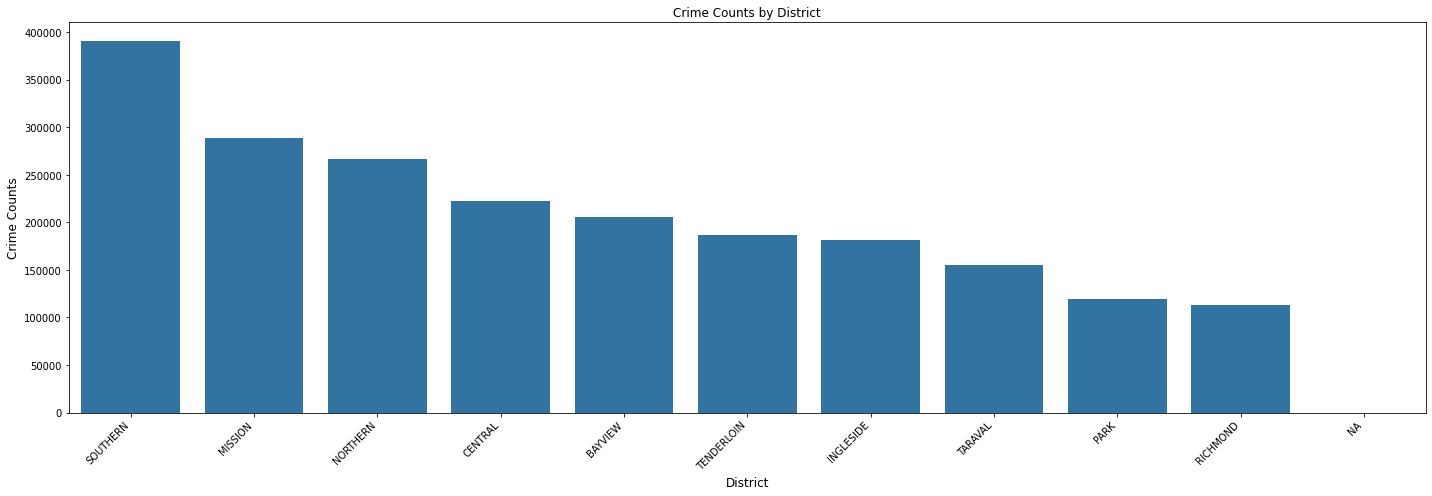

In [0]:
fig, axp = plt.subplots(1, 1, figsize=[20, 7])
sb.barplot(x = 'PdDistrict', y ='count', data=q2_result_df, ax=axp, color='C0')
axp.set_title('Crime Counts by District')
axp.set_xlabel('District', fontsize=12)
axp.set_ylabel('Crime Counts', fontsize=12)
axp.set_xticklabels(axp.get_xticklabels(), rotation=45, horizontalalignment='right') 
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## Crimes on "Sunday" at "SF downtown".   

 

Here, we defined San Francisco downtown based on the spatial boundaries of latitude and longitude. The coordinates for San Francisco are approximately 37.773972 (latitude) and -122.431297 (longitude). So we assumed SF downtown spacial range: X (-122.4213,-122.4313), Y(37.7540,37.7740).

Crime incident in SF on Sunday started to increase since 2012 likely because the increasing poplulation and tourist growth since 2012 especially with an influx of younger, more mobile residents who engaged in more weekend activities. This could naturally lead to more reported crime on Sundays, when public spaces and entertainment areas were crowded.


In [0]:

from pyspark.sql.functions import hour, month, year
from pyspark.sql.functions import to_timestamp

# add date and time info
df_opt1 = df_opt1.withColumn('IncidentTime', to_timestamp(df_opt1['Time'],'HH:mm')) 
df_opt1 = df_opt1.withColumn("Year",year(df_opt1.Date)) 
df_opt1 = df_opt1.withColumn("Month",month(df_opt1.Date)) 
df_opt1 = df_opt1.withColumn('IncidentTime', to_timestamp(df_opt1['Time'],'HH:mm')) 
# extract hour from incident time
df_opt1 = df_opt1.withColumn('Hour',hour(df_opt1['IncidentTime']))

# sf downtown
sf_downtown_sun = (df_opt1.X > -122.4313) & (df_opt1.X < -122.4213) & (df_opt1.Y < 37.7740) & (df_opt1.Y > 37.7540 ) & (df_opt1.DayOfWeek == 'Sunday')
spark_df_q3 = df_opt1.filter(sf_downtown_sun).groupby('Date').count().orderBy('Date')
# convert string to date
display(spark_df_q3)

Date,count
2003-01-05,13
2003-01-12,20
2003-01-19,17
2003-01-26,13
2003-02-02,14
2003-02-09,22
2003-02-16,12
2003-02-23,14
2003-03-02,16
2003-03-09,8


In [0]:
# convert to pandas for time series analysis
pandas_df_q3 = spark_df_q3.toPandas()
pandas_df_q3['Date'] = pd.to_datetime(pandas_df_q3['Date']) 
pandas_df_q3.set_index('Date', inplace=True)
crime_count = pandas_df_q3['count']

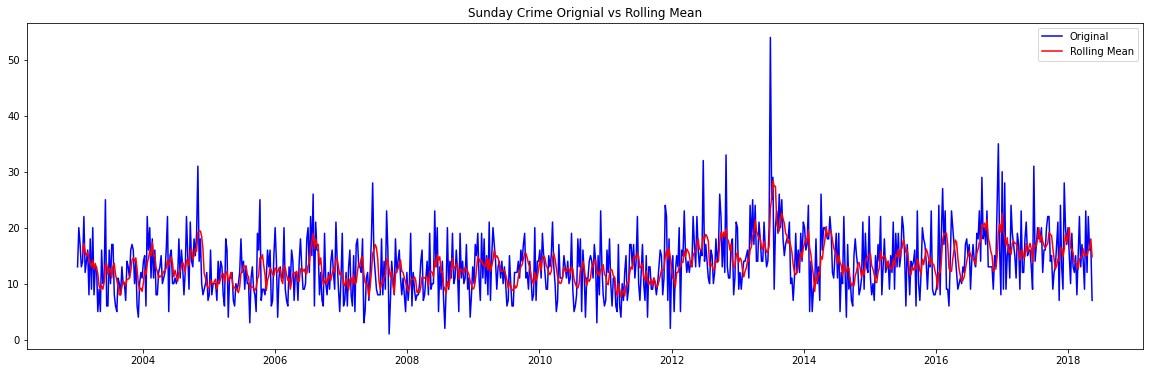

In [0]:
import matplotlib.pyplot as plt

# Calculate rolling mean
rollingmean = crime_count.rolling(window=5).mean()

# Set the figure size
plt.figure(figsize=(20, 6))

# Plot the original data and rolling mean
plt.plot(crime_count, color='blue', label='Original')
plt.plot(rollingmean, color='red', label='Rolling Mean')

# Add legend and title
plt.legend(loc='best')
plt.title('Sunday Crime Orignial vs Rolling Mean')

# Display the plot
plt.show()

The crime incidents were exceptionally high on June 30, 2013, likely due to protests, parades, or celebrations following the U.S. Supreme Court's decision to strike down the Defense of Marriage Act (DOMA) on June 26, 2013, which increase the posibility of conflict,offense, and theft.

In [0]:
max_crime_row = pandas_df_q3['count'].idxmax()

# Extract the date and max crime count
max_crime_row

Out[20]: Timestamp('2013-06-30 00:00:00')

In [0]:
# crimes count near peak crime
peak_filter = (df_opt1.Date >= '2013-06-20') & (df_opt1.Date <= '2013-07-10') & (df_opt1.X > -122.4313) & (df_opt1.X < -122.4213) & (df_opt1.Y < 37.7740) & (df_opt1.Y > 37.7540 )

spark_df_q3_peak = df_opt1.filter(peak_filter)
spark_df_q3_peak_by_loc = spark_df_q3_peak.groupby('Date').count().orderBy('Date')
display(spark_df_q3_peak_by_loc)




Date,count
2013-06-20,17
2013-06-21,13
2013-06-22,14
2013-06-23,20
2013-06-24,18
2013-06-25,12
2013-06-26,9
2013-06-27,8
2013-06-28,19
2013-06-29,41


Databricks visualization. Run in Databricks to view.

## Crime by  month of 2015, 2016, 2017, 2018

The overall trend showed a decline in crime incidents without obvious seasonality, particularly with a sharp drop starting in Feb 2018. The significant decrease in crimes from 2018/02 was likely because the San Francisco Police Department (SFPD) started to put more effort to address local crime trends. For instance, SFFD expanded its foot patrols across the city, especially in areas with high crime rates, like the Mid-Market corridor and Union Plaza. This visible police presence helped deter crimes such as assaults, thefts, and vehicle break-ins. Besides, the SFPD held "Park Smart" public education campaign played a significant role in reducing property crimes, particularly auto burglaries.

In [0]:
spark_df_q4 = df_opt1.filter(df_opt1['Year'].isin('2015', '2016', '2017', '2018')).groupBy('Year', 'Month').count().orderBy('Year', 'Month')
display(spark_df_q4)

Year,Month,count
2015,1,13181
2015,2,11882
2015,3,13463
2015,4,12526
2015,5,13318
2015,6,12853
2015,7,12949
2015,8,13317
2015,9,12476
2015,10,12697


In [0]:
# Create 'YearMonth' column by concatenating 'Year' and 'Month'
spark_df_q4 = spark_df_q4.withColumn('YearMonth', 
                             F.concat(F.col('Year'), 
                                      F.lit('-'), 
                                      F.lpad(F.col('Month'), 2, '0')))

# Display the DataFrame with the new 'YearMonth' column
# Remove 2018-05 because it's a half month
spark_df_q4 = spark_df_q4.filter(spark_df_q4.YearMonth != '2018-05')
display(spark_df_q4)

Databricks visualization. Run in Databricks to view.

Year,Month,count,YearMonth
2015,1,13181,2015-01
2015,2,11882,2015-02
2015,3,13463,2015-03
2015,4,12526,2015-04
2015,5,13318,2015-05
2015,6,12853,2015-06
2015,7,12949,2015-07
2015,8,13317,2015-08
2015,9,12476,2015-09
2015,10,12697,2015-10


## Crimes on 01/01 and give travel suggestion to visit SF

We focused on January 1st (New Year's Day) from 2015 to 2018 for this analysis. The crime rates consistently peaked between 12 AM and 2 AM, likely due to social events, parties, and alcohol consumption associated with New Year celebrations. Additionally, there were higher crime rates at 12 PM and 6 PM, which may coincide with people being out for meals. After 7 PM, crime occurrences decreased, possibly as people returned home to prepare for the workday ahead.


In [0]:
spark_df_q5 = df_opt1.filter(df_opt1['Date'].isin('2015-01-01', '2016-01-01', '2017-01-01','2018-01-01')).groupBy('Year','Hour').count().orderBy("count", ascending=False)
display(spark_df_q5)

Year,Hour,count
2015,0,107
2016,0,104
2017,0,72
2015,1,49
2016,2,47
2016,12,47
2015,12,41
2018,0,41
2016,1,37
2016,18,37


Databricks visualization. Run in Databricks to view.

The crimes were the most intense in the central and eastern parts of SF, including Downtown and Mission District and surrounding areas possibly related to nightlife or residential areas with more activities. The Richmond District also showed notable crime concentration, likely due to their mixed residential and commercial nature. The most common crimes in these areas were theft and assault.


In [0]:
# get the crime type for peak crime hours
spark_df_q5_peak = df_opt1.filter(df_opt1['Date'].isin('2015-01-01', '2016-01-01', '2017-01-01','2018-01-01') & df_opt1['Hour'].isin(0,1,2,12,18) )

In [0]:
spark_df_q5_peak_cat = spark_df_q5_peak.groupBy('category').count().orderBy("count", ascending=False)
display(spark_df_q5_peak_cat)

category,count
LARCENY/THEFT,188
NON-CRIMINAL,158
OTHER OFFENSES,109
ASSAULT,93
SUSPICIOUS OCC,50
VANDALISM,37
VEHICLE THEFT,25
MISSING PERSON,20
BURGLARY,20
FRAUD,18


In [0]:
import folium
from folium.plugins import HeatMap

# Collect necessary data into a Pandas DataFrame (assuming columns 'Latitude' and 'Longitude' exist)
crime_data = spark_df_q5_peak.select("Y", "X").toPandas()

# Create a base map centered around San Francisco
sf_map = folium.Map(location=[37.7749, -122.4194], zoom_start=13)

# add heap layer
heat_data = [[row['Y'], row['X']] for index, row in crime_data.iterrows()]
HeatMap(heat_data).add_to(sf_map)

# Save the map as an HTML file
sf_map.save("sf_crime_map.html")

# If in a Jupyter notebook environment, display the map directly
sf_map

Make this Notebook Trusted to load map: File -> Trust Notebook <iframe srcdoc="<!DOCTYPE html>
<html>
<head>
 
 <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
 
 <script>
 L_NO_TOUCH = false;
 L_DISABLE_3D = false;
 </script>
 
 <style>html, body {width: 100%;height: 100%;margin: 0;padding: 0;}</style>
 <style>#map {position:absolute;top:0;bottom:0;right:0;left:0;}</style>
 <script src="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.js"></script>
 <script src="https://code.jquery.com/jquery-3.7.1.min.js"></script>
 <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/js/bootstrap.bundle.min.js"></script>
 <script src="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js"></script>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://netdna.bootstrapcdn.com/bootstrap/3.0.0/css/bootstrap-glyphicons.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/@fortawesome/fontawesome-free@6.2.0/css/all.min.css"/>
 <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css"/>
 
 <meta name="viewport" content="width=device-width,
 initial-scale=1.0, maximum-scale=1.0, user-scalable=no" />
 <style>
 #map_7cb98d452931a33c743903a3a360072f {
 position: relative;
 width: 100.0%;
 height: 100.0%;
 left: 0.0%;
 top: 0.0%;
 }
 .leaflet-container { font-size: 1rem; }
 </style>
 
 <script src="https://cdn.jsdelivr.net/gh/python-visualization/folium@main/folium/templates/leaflet_heat.min.js"></script>
</head>
<body>
 
 
 <div class="folium-map" id="map_7cb98d452931a33c743903a3a360072f" ></div>
 
</body>
<script>
 
 
 var map_7cb98d452931a33c743903a3a360072f = L.map(
 "map_7cb98d452931a33c743903a3a360072f",
 {
 center: [37.7749, -122.4194],
 crs: L.CRS.EPSG3857,
 zoom: 13,
 zoomControl: true,
 preferCanvas: false,
 }
 );

 

 
 
 var tile_layer_e9e5aff2c59349ad04f82cfed753d6aa = L.tileLayer(
 "https://tile.openstreetmap.org/{z}/{x}/{y}.png",
 {"attribution": "\u0026copy; \u003ca href=\"https://www.openstreetmap.org/copyright\"\u003eOpenStreetMap\u003c/a\u003e contributors", "detectRetina": false, "maxNativeZoom": 19, "maxZoom": 19, "minZoom": 0, "noWrap": false, "opacity": 1, "subdomains": "abc", "tms": false}
 );
 
 
 tile_layer_e9e5aff2c59349ad04f82cfed753d6aa.addTo(map_7cb98d452931a33c743903a3a360072f);
 
 
 var heat_map_b4211bb880ec07fddd4a4a3730f471f6 = L.heatLayer(
 [[37.781526271747, -122.40950430935], [37.7923158747647, -122.410845624227], [37.7601858144207, -122.467662674102], [37.775420706711, -122.403404791479], [37.7504443648923, -122.396408273119], [37.77241189340805, -122.50774902862975], [37.7870966495663, -122.41072162587], [37.7899019822508, -122.407114491118], [37.7885335775983, -122.401738283506], [37.7785349354394, -122.41742986085], [37.7088054432465, -122.452664083403], [37.7767584601298, -122.431384548289], [37.7878246694374, -122.397032436528], [37.7821490263522, -122.434165498104], [37.7339497680852, -122.489713969124], [37.8081099573456, -122.40905521632], [37.7451850943238, -122.442155766765], [37.775420706711, -122.403404791479], [37.7981172349798, -122.401027377105], [37.7966976738334, -122.398324392842], [37.7648664738135, -122.449770936688], [37.8051625655624, -122.432957440518], [37.7829514828801, -122.413259498719], [37.7494623837712, -122.478356826784], [37.7820088761349, -122.439086501493], [37.7767239668024, -122.495310429803], [37.78369522697492, -122.4107916776447], [37.7642555194629, -122.442128945417], [37.78369522697492, -122.4107916776447], [37.7740604119579, -122.437612766191], [37.7824014072132, -122.403890955445], [37.7244627349044

In [0]:
# Get crime type for peak areas

sf_downtown_mask = (spark_df_q5_peak['X'] > -122.4313) & (spark_df_q5_peak['X'] < -122.4213) & (spark_df_q5_peak['Y'] < 37.7740) & (spark_df_q5_peak['Y'] > 37.7540)

peak_area_other = spark_df_q5_peak['PdDistrict'].isin(['MISSION', 'CENTRAL', 'RICHMOND'])

# Filter for crimes occurring in either downtown SF or the specified peak districts
spark_df_q5_peak_area = spark_df_q5_peak.filter(sf_downtown_mask | peak_area_other)

# Group by crime category and count occurrences, sorting in descending order of frequency
spark_df_q5_peak_cat = spark_df_q5_peak_area.groupBy('category').count().orderBy("count", ascending=False)

# Display the result
display(spark_df_q5_peak_cat)


category,count
NON-CRIMINAL,68
LARCENY/THEFT,62
ASSAULT,36
OTHER OFFENSES,33
SUSPICIOUS OCC,17
VANDALISM,11
WARRANTS,7
EMBEZZLEMENT,7
VEHICLE THEFT,7
BURGLARY,7


### Recommendations
Based on these findings, if visiting SF on New Year's Day, we recommend:
1.  Avoid hanging out in Downtown, Mission, and Richmond for celebrations between 12 AM and 2 AM, as well as during lunch and dinner hours around 12 PM and 6 PM. 
2. If unavoidable, visitors should be cautious of their personal belongings and stay alert for intoxicated individuals, drug activity, and homelessness in these areas.

## Find out the top-3 danger disricts and their crime category and give advices



We identified the top three high-risk districts based on the highest number of crime incidents over the past three years, as the most recent data provides more relevant and actionable insights. The top 3 dangerous districts were South SF, Mission and Northern SF.

Within these three districts, the most common crime was larceny/theft. Additionally, all three districts experienced high crime rates around 12 PM and between 17 PM and 18 PM, likely coinciding with lunch breaks, people leaving work, or heading out for dinner. The Mission District also had elevated crime levels around midnight, likely due to its many bars and clubs that drew nightlife crowds.

In [0]:
spark_df_q6 = df_opt1.filter(df_opt1['Year'] >= 2016)
q6_result = spark_df_q6.groupBy("PdDistrict").count().orderBy("count", ascending=False)
display(q6_result)

PdDistrict,count
SOUTHERN,64097
MISSION,46604
NORTHERN,46550
CENTRAL,42019
BAYVIEW,30706
INGLESIDE,25286
TARAVAL,25008
TENDERLOIN,20983
RICHMOND,20338
PARK,18948


In [0]:
spark_df_q6_mission= spark_df_q6.filter(spark_df_q6['PdDistrict']=='MISSION')
spark_df_q6_mission_result = spark_df_q6_mission.groupBy('category','Hour').count()
display(spark_df_q6_mission_result)

category,Hour,count
DRUG/NARCOTIC,23,41
FRAUD,15,31
STOLEN PROPERTY,21,8
VANDALISM,22,159
ROBBERY,14,43
LIQUOR LAWS,11,2
DRUNKENNESS,17,9
SUSPICIOUS OCC,6,45
WEAPON LAWS,10,20
NON-CRIMINAL,15,313


Databricks visualization. Run in Databricks to view.

In [0]:
spark_df_q6_south= spark_df_q6.filter(spark_df_q6['PdDistrict']=='SOUTHERN')
spark_df_q6_south_result = spark_df_q6_south.groupBy('category','Hour').count()
display(spark_df_q6_south_result)

category,Hour,count
ASSAULT,18,259
LARCENY/THEFT,9,695
FRAUD,15,59
STOLEN PROPERTY,21,34
DRUG/NARCOTIC,23,70
DRUNKENNESS,6,3
VANDALISM,22,228
ROBBERY,14,61
DRUNKENNESS,17,6
FORGERY/COUNTERFEITING,23,1


Databricks visualization. Run in Databricks to view.

In [0]:
spark_df_q6_north= spark_df_q6.filter(spark_df_q6['PdDistrict']=='NORTHERN')
spark_df_q6_north_result = spark_df_q6_north.groupBy('category','Hour').count()
display(spark_df_q6_north_result)

category,Hour,count
FRAUD,15,52
STOLEN PROPERTY,21,16
DRUG/NARCOTIC,23,44
VANDALISM,22,195
ROBBERY,14,38
LIQUOR LAWS,11,1
DRUNKENNESS,17,1
SUSPICIOUS OCC,6,35
WEAPON LAWS,10,8
TRESPASS,22,14


Databricks visualization. Run in Databricks to view.

### Recommendations
Bases on these insights, we recommend:
1. Increase police presence during peak hours (12 PM, 5-6 PM) in all districts, focusing on high-traffic areas near offices, restaurants, and public transit.
2. Boost night patrols in the Mission District around midnight, particularly in areas with bars and clubs to manage the nightlife-related crime spike.
3. Implement targeted anti-theft operations by deploying undercover officers during peak times and raising public awareness in theft hotspots.

## For different category of crime, find the percentage of resolution. Based on the output, give hints to adjust the policy.

Similarly as Q6, here we only considered data since 2016 due to the consideration of data representative. 

Most of the resolutions were None meaning it was either unresolved or the resolution were missing especially for mirror offense like Larceny/Theft. For not None rosulation, the most common one was arrested, booked. The serious crimes, like Arson, Kidnapping, and Drug/Narcotic offenses, showed more resolution activity . This might indicated a higher prioritization or clearer pathways for resolution in these categories.

In [0]:
q7_result = spark_df_q6.groupBy("category","Resolution").count().orderBy("count", ascending=False)
display(q7_result)

category,Resolution,count
LARCENY/THEFT,NONE,97641
NON-CRIMINAL,NONE,36260
OTHER OFFENSES,"ARREST, BOOKED",26073
VANDALISM,NONE,18710
ASSAULT,NONE,17097
OTHER OFFENSES,NONE,16108
SUSPICIOUS OCC,NONE,12364
VEHICLE THEFT,NONE,12343
WARRANTS,"ARREST, BOOKED",11627
BURGLARY,NONE,11371


Databricks visualization. Run in Databricks to view.

### Recommendation
The SF police could designate a dedicated team to focus on minor offenses with the highest social impact. By assigning fixed personnel to consistently handle the same types of cases, the resolution process would become more streamlined, leading to a higher resolution rate.

## Crimes with Low Resoluations

Larceny/Theft was the most common crime with a low resolution rate. We aim edto explore the 'Descript' column to identify the most frequently stolen items and raise public awareness to encourage better precautions.

In [0]:
from pyspark.sql.functions import col, lower

spark_df_q8 = spark_df_q6.filter(spark_df_q6['category']=='LARCENY/THEFT')
spark_df_q8_lower = spark_df_q8.withColumn("Descript", lower(col("Descript")))
pandas_df_q8 = spark_df_q8_lower.select("Descript").toPandas()



In [0]:
import nltk
from nltk.corpus import stopwords
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from collections import Counter

# Download NLTK stopwords if not already available
nltk.download('stopwords')
stop_words = set(stopwords.words('english')).union({"theft", "larceny", "stolen", "property", "taken"})

# Preprocess function (assumes text is in pandas_df_q8["Descript"])
def preprocess(text):
    text = text.lower()
    words = [word for word in simple_preprocess(text) if word not in stop_words]
    return words

# Apply preprocessing
processed_docs = pandas_df_q8["Descript"].apply(preprocess).tolist()



# Flatten the list of lists and count word frequencies
all_words = [word for doc in processed_docs for word in doc]
word_counts = Counter(all_words)

# Print the most common words
print("Word Counts:", word_counts.most_common(20))




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Word Counts: [('grand', 67726), ('auto', 63440), ('locked', 57138), ('petty', 31895), ('unlocked', 6872), ('building', 6823), ('shoplifting', 5067), ('person', 3190), ('bicycle', 1881), ('pickpocket', 1842), ('attempted', 1083), ('lost', 786), ('vehicle', 746), ('computers', 343), ('cell', 343), ('phones', 343), ('merchant', 197), ('library', 197), ('strip', 183), ('checks', 167)]


The most common types of theft in SF were auto theft, shoplifting, and bicycle theft.

### Recommendation
1. When parking in SF, we recommend choosing parking lots or areas with surveillance, especially in high-risk neighborhoods like Downtown, Mission, and Richmond.
2. Retailers should establish partnerships with law enforcement to improve theft prevention, increase security patrols, and track repeat offenders.
3. To enhance bike security, we recommend using high-quality locks, registering bikes, and collaborating with bike shops to promote anti-theft practices.

## Conclusion

In this project, we conducted a comprehensive analysis of 550M crime-related records from 37 crime categories in San Francisco from 2023/01/01 to 2018/05/15 to identify patterns, high-risk areas, and prevalent types of crime and their resolution, aiming to support law enforcement and community safety initiatives. 

Using Spark, we processed large datasets, applied OLAP techniques for in-depth analysis, and visualized results such crimes across district, category and time, crime trend, crime heap map. Based on these, we could identify significant crime trends including peak hours and high-crime areas, enabling data-driven recommendations for public safety and crime prevention. 

According to the exploration, we found:

1. SF became safer since February 2018, likely due to increased efforts by the San Francisco Police Department (SFPD) to address local crime trends.
2. The most dangerous districts were South SF, Mission, and Northern SF, which had higher crime rates especially theft/larceny due to their active nightlife, commercial centers, and mixed residential areas. Peak crime hours were around lunchtime, dinnertime, and midnight.
3. SFPD prioritized more serious crimes, resulting in higher resolution rates for these offenses, while minor offenses tended to have lower resolution rates.
4. For theft, the most frequent crime in, the most common types were auto theft, shoplifting, and bicycle theft.


## Recommendations:

To reduce crime occurrences, we recommend the following actions:

1. For Residents and Visitors, they should avoid high-crime areas in South SF, Mission, and Northern SF during peak hours (lunchtime, dinnertime, and midnight). If unavoidable, remain vigilant about personal belongings and be cautious of intoxicated individuals, drug activity, and homelessness in these areas.

2. For SF Police should i3ncrease police presence during peak hours in South SF, Mission, and Northern SF, especially in high-traffic areas near offices, restaurants, and bars. Besides, they could deploy undercover officers in theft hotspots during peak times and run public awareness campaigns to reduce theft.

To address low resolution rates for minor offenses, we recommend:

1. SF police could assign a specialized team to focus on minor offenses with significant social impact to improve resolution rates.

To protect people's property safety, we recommend:

1. When parking in SF, use parking lots or areas with surveillance, especially in high-risk neighborhoods like Downtown, Mission, and Richmond.

2. Retailers should partner with law enforcement to enhance theft prevention, increase security patrols, and monitor repeat offenders.

3. Bike owners should use high-quality locks, register bikes, and collaborate with bike shops to promote anti-theft practices.